In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
import librosa
import librosa.display
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load data
paths = []
labels = []
for dirname, _, filenames in os.walk('D:\\files\Datasets\Tess\TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [3]:
# Create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

In [4]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [6]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
X = [x for x in X_mfcc]
X = np.array(X)
X = np.expand_dims(X, -1)

In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()
y.shape

(2800, 7)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
n_samples_train, n_steps, n_features = X_train.shape
n_samples_test, _, _ = X_test.shape
X_train_2d = X_train.reshape((n_samples_train, n_steps * n_features))
X_test_2d = X_test.reshape((n_samples_test, n_steps * n_features))


In [12]:
# Data preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

In [20]:
# Apply Truncated SVD
svd = TruncatedSVD(n_components=10)
X_train_transformed = svd.fit_transform(X_train_scaled)
X_test_transformed = svd.transform(X_test_scaled)

In [33]:
X_train_reshaped = X_train_transformed.reshape(X_train_transformed.shape[0], X_train_transformed.shape[1], 1, 1)
X_test_reshaped = X_test_transformed.reshape(X_test_transformed.shape[0], X_test_transformed.shape[1], 1, 1)

In [34]:
# CNN model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train_transformed.shape[1], 1, 1), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))


In [35]:

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
# Set early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [37]:
X_train_transformed = X_train_transformed.reshape(X_train_transformed.shape[0], 10, 1, 1)


In [44]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [48]:
# Train the model
history = model.fit(X_train_transformed, y_train,validation_split=0.2, epochs=50, batch_size=32)

Epoch 1/50
56/56 [==============================] - 0s 6ms/step - loss: 2.0794e-04 - accuracy: 1.0000 - val_loss: 8.0574e-06 - val_accuracy: 1.0000
Epoch 2/50
56/56 [==============================] - 0s 3ms/step - loss: 1.3895e-04 - accuracy: 1.0000 - val_loss: 7.6099e-06 - val_accuracy: 1.0000
Epoch 3/50
56/56 [==============================] - 0s 3ms/step - loss: 7.4813e-05 - accuracy: 1.0000 - val_loss: 7.6791e-06 - val_accuracy: 1.0000
Epoch 4/50
56/56 [==============================] - 0s 3ms/step - loss: 1.2374e-04 - accuracy: 1.0000 - val_loss: 5.4494e-06 - val_accuracy: 1.0000
Epoch 5/50
56/56 [==============================] - 0s 3ms/step - loss: 8.0254e-05 - accuracy: 1.0000 - val_loss: 5.1167e-06 - val_accuracy: 1.0000
Epoch 6/50
56/56 [==============================] - 0s 3ms/step - loss: 9.0636e-05 - accuracy: 1.0000 - val_loss: 4.7134e-06 - val_accuracy: 1.0000
Epoch 7/50
56/56 [==============================] - 0s 3ms/step - loss: 1.0285e-04 - accuracy: 1.0000 - val_loss

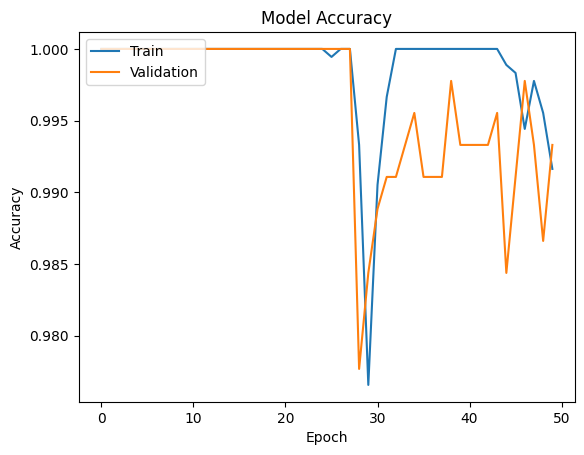

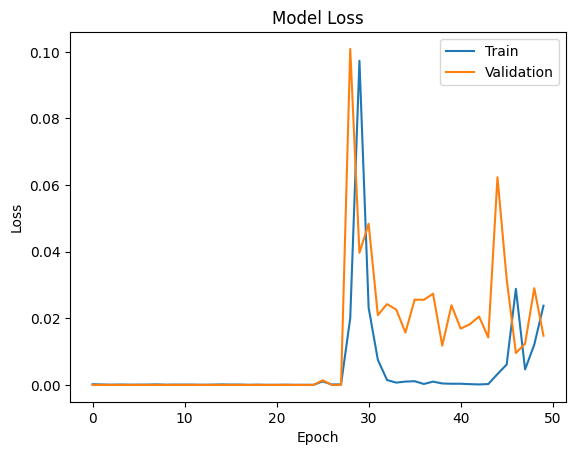

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot Training Loss vs Validation Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()